In [2]:
%config IPCompleter.greedy=True

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

import copy

### This is the network that maps the input data to the latent space where it will be clustered

In [4]:
class Embedder(nn.Module):

    def __init__(self, hidden_dim):
        super(Embedder, self).__init__()
        self.l0 = nn.Linear(2, 8)
        self.l0.weight.data.copy_(torch.randn(8, 2) * 1)

        self.l1 = nn.Linear(8, 8)
        self.l1.weight.data.copy_(torch.randn(8, 8) * 1)

        self.l2 = nn.Linear(8, hidden_dim)
        self.l2.weight.data.copy_(torch.randn(hidden_dim, 8) * 5)

    def forward(self, x):
        return self.l2(torch.sigmoid(self.l1(torch.sigmoid(self.l0(x)))))
        self.l1 = torch.optim

In [5]:
def plot_transformation_field(data, transformed):
    """ has to be 2D data
    plots an arrow from each point in data to the corresponding in transformed """
    for i in range(data.shape[0]):
        plt.arrow(data[i][0], data[i][1], transformed[i][0]-data[i][0], transformed[i][1]-data[i][1])

In [6]:
def cluster_loss(transformed, means):
    loss = 0
    for m in means:
        # print(m)
        for x in transformed:
            loss -= loss_radius * torch.exp(-((x-m)**2)/loss_radius)

    return loss.sum()

In [7]:
def initialize_clusters(k, R):
    """ k equally space clusters in an nD space
    range: [(min, max) for i in nD] """

    return torch.Tensor([[(D[0]-D[1])*(i+1)/(k+1) + D[1] for D in R] for i in range(k)]).float()

In [8]:
def plot_clusters(clusters):
    """ only works in 2D """
    for c in clusters:
        plt.scatter(c[0], c[1], color='r')

# Let's talk about the cluster loss

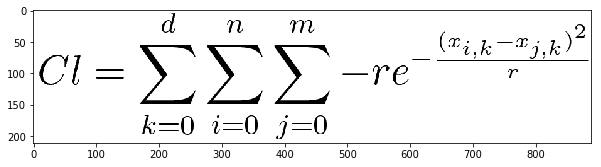

In [9]:
matplotlib.rcParams['figure.figsize'] = [10, 5]
plt.imshow(plt.imread('CL.png'), cmap='gray')


***d*** is the number of dimensions in the latent space, ***n*** and ***m*** are the number of datapoints and of clusters respectively

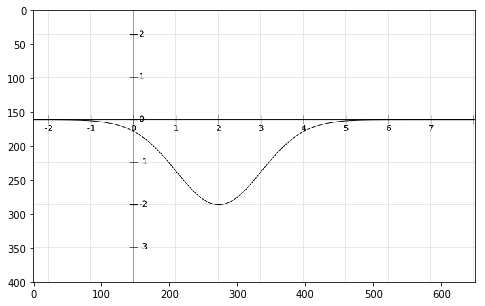

In [10]:
plt.imshow(plt.imread('CLplot.png'), cmap='gray')

#### The plot of the cluster loss function for a 1D latent space with only one datapoint, with one cluster in x=2 and with r=2.

As you can see this loss makes sure that only datapoints already close to the cluster get further attracted to it. This way each point get's pulled to the closest cluster. If some datapoints are too far away from any cluster for them to be moved substantially, that could be a signal for the need of a new cluster (this isn't implemented in any way at the moment though). 

### A toy task 

To give a sense of how the data would ideally be optimized for this loss function here is optimization performed directly on the data. Obviously each point in the data will move towards the closest cluster centre. 

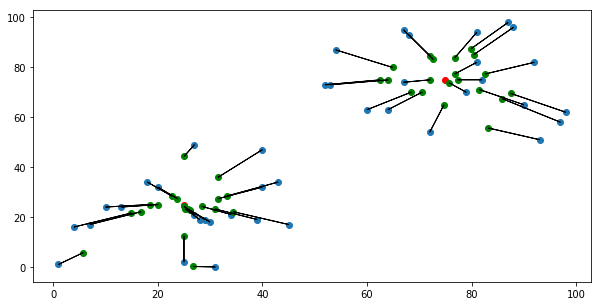

In [11]:
K = 2           # number of clusters
n_points = 40

data = nn.Parameter(torch.from_numpy(
    np.concatenate(
        (np.random.randint(0, 50, (n_points//2, 2)), np.random.randint(50, 100, (n_points//2, 2))), axis=0)).float())

loss_radius = 25
clusters = torch.Tensor([[25, 25], [75, 75]])

optimizer = optim.Adam([data], lr=4e-3)    # in the toy task we optimise the data directly 

to_plot_clusters = copy.deepcopy(clusters.detach())
to_plot_initial_data = copy.deepcopy(data.detach().data.numpy())

for i in range(int(1e3)):
    cl = cluster_loss(data, clusters)
    
    cl.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

    
    
plt.scatter(to_plot_initial_data[:, 0], to_plot_initial_data[:, 1])
plot_clusters(copy.deepcopy(clusters.detach()))
data = data.detach().data.numpy()
plt.scatter(data[:, 0], data[:, 1], color='g')
plot_transformation_field(to_plot_initial_data, data)

This is only after 1000 iterations

### The real thing

This time we will use the embedder network and consider the cluster loss on the data in the latent space. 

We will also introduce a reconstruction loss to ensure we do not lose the information in the data, it would be too easy otherwise for the network to simply overfit to the cluster centers. 

Finally, the cluster centers' locations will be udated accoring to the same loss function as well.

RECONSTRUCTION: 3497.7236 CLUSTERING: -152.7704 out of -368.21667
RECONSTRUCTION: 3312.8452 CLUSTERING: -149.63162 out of -368.21667
RECONSTRUCTION: 2757.3765 CLUSTERING: -111.98077 out of -368.21667
RECONSTRUCTION: 1263.6552 CLUSTERING: -17.41298 out of -368.21667
RECONSTRUCTION: 622.8407 CLUSTERING: -25.437548 out of -368.21667
RECONSTRUCTION: 496.14 CLUSTERING: -25.27274 out of -368.21667
RECONSTRUCTION: 455.61127 CLUSTERING: -27.248463 out of -368.21667
RECONSTRUCTION: 395.38745 CLUSTERING: -31.591331 out of -368.21667
RECONSTRUCTION: 337.58633 CLUSTERING: -33.233463 out of -368.21667
RECONSTRUCTION: 261.2329 CLUSTERING: -34.05532 out of -368.21667
RECONSTRUCTION: 161.48445 CLUSTERING: -31.883768 out of -368.21667
RECONSTRUCTION: 88.06071 CLUSTERING: -32.798233 out of -368.21667
RECONSTRUCTION: 52.833374 CLUSTERING: -40.428844 out of -368.21667
RECONSTRUCTION: 42.935165 CLUSTERING: -38.537167 out of -368.21667
RECONSTRUCTION: 35.705135 CLUSTERING: -35.961197 out of -368.21667
RECON

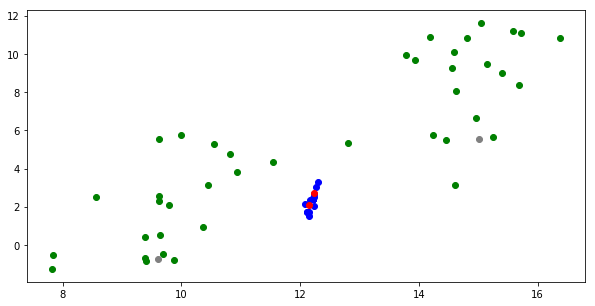

In [13]:
K = 2           # number of clusters
n_points = 40

data = torch.from_numpy(
    np.concatenate(
        (np.random.randint(0, 50, (n_points//2, 2)), np.random.randint(50, 100, (n_points//2, 2))), axis=0)).float()

t_dim = 5
embedder = Embedder(t_dim)
decoder = nn.Sequential(nn.Linear(t_dim, 5), nn.ReLU(), nn.Linear(5, 5), nn.ReLU(), nn.Linear(5, 2))

transformed = embedder(Variable(data))
to_plot_initial_transformed = copy.deepcopy(transformed.data.numpy())

max_values, _ = torch.max(transformed, 0)
min_values, _ = torch.min(transformed, 0)

R = torch.cat((max_values.unsqueeze(0), min_values.unsqueeze(0)), dim=0).data.numpy().T

clusters = nn.Parameter(initialize_clusters(2, R))
to_plot_initial_clusters = copy.deepcopy(clusters.detach().data.numpy())

p_optimizer = optim.Adam(list(embedder.parameters())+[clusters], lr=1e-4)
d_optimizer = optim.Adam(decoder.parameters(), lr=1e-4)

loss_radius = torch.norm(clusters[0] - clusters[1], 2) / 2

min_loss = -(K*loss_radius*n_points*t_dim*clusters.shape[0])


for i in range(int(3e4)):

    reconstruction_loss = F.mse_loss(decoder(transformed), data)
    clustering_loss = cluster_loss(transformed, clusters)

    loss = clustering_loss + reconstruction_loss

    loss.backward(retain_graph=True)            # TODO find out why retain_graph has to be True

    
    p_optimizer.step()
    p_optimizer.zero_grad()

    d_optimizer.step()
    d_optimizer.zero_grad()

    transformed = embedder(Variable(data))

    if i % 1000 == 0:
        print('RECONSTRUCTION:', reconstruction_loss.data.numpy(),
              'CLUSTERING:', clustering_loss.data.numpy(), 'out of', min_loss.data.numpy())
        
plt.scatter(to_plot_initial_transformed[:, 0], to_plot_initial_transformed[:, 1], color='b')
plt.scatter(to_plot_initial_clusters[:, 0], to_plot_initial_clusters[:, 1], color='r')

plt.scatter(transformed.data.numpy()[:, 0], transformed.data.numpy()[:, 1], color='g')
plt.scatter(clusters.detach().data.numpy()[:, 0], clusters.detach().data.numpy()[:, 1], c=(0.5, 0.5, 0.5))
